# Preprocessing

In [29]:
!pip install imblearn
!pip3 install tensorflow_decision_forests --upgrade
!pip install keras-tuner -q
!pip install optuna
!pip install pykan
!pip install scikit-plot

import pandas as pd
from scipy import stats
import numpy as np
import math

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from scikitplot.metrics import plot_ks_statistic

from itertools import product
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.transforms
from torchvision.transforms import ToTensor
from torchvision.ops import MLP
from torch import optim

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import keras_tuner
import optuna as opt

from IPython.display import clear_output
import tensorflow_decision_forests as tfdf

from kan import KAN

In [30]:
!gdown --folder https://drive.google.com/drive/folders/1R610tk2mrz2VWcOD2cYL3xk-ZLqUwp-m?usp=drive_link -O /content/database

Retrieving folder contents
Processing file 11Rzl81S2tDqEufdhHQ2zJrT51c8Vh4kM test.csv
Processing file 1UKKKRbrzbZDvpcQFYNGaqlrGur1RmkGP train.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=11Rzl81S2tDqEufdhHQ2zJrT51c8Vh4kM
To: /content/database/test.csv
100% 3.04M/3.04M [00:00<00:00, 45.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UKKKRbrzbZDvpcQFYNGaqlrGur1RmkGP
To: /content/database/train.csv
100% 12.2M/12.2M [00:00<00:00, 126MB/s]
Download completed


In [31]:
train_df = pd.read_csv('database/train.csv', index_col=0)
test_df = pd.read_csv('database/test.csv', index_col=0)
train_df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## Train Validation Split

In [32]:
original_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

In [33]:
train_df, validation_df = train_test_split(original_df,test_size= 0.25, stratify=original_df['satisfaction'])

print('original_df: ',len(original_df))
print('train_df size: ', len(train_df), "| validation_df size:", len(validation_df))
print(f'train_df: {len(train_df)/len(original_df)}%', f"| validation_df: {len(validation_df)/len(original_df)}%",)

original_df:  103904
train_df size:  77928 | validation_df size: 25976
train_df: 0.75% | validation_df: 0.25%


## Outliers

<Axes: >

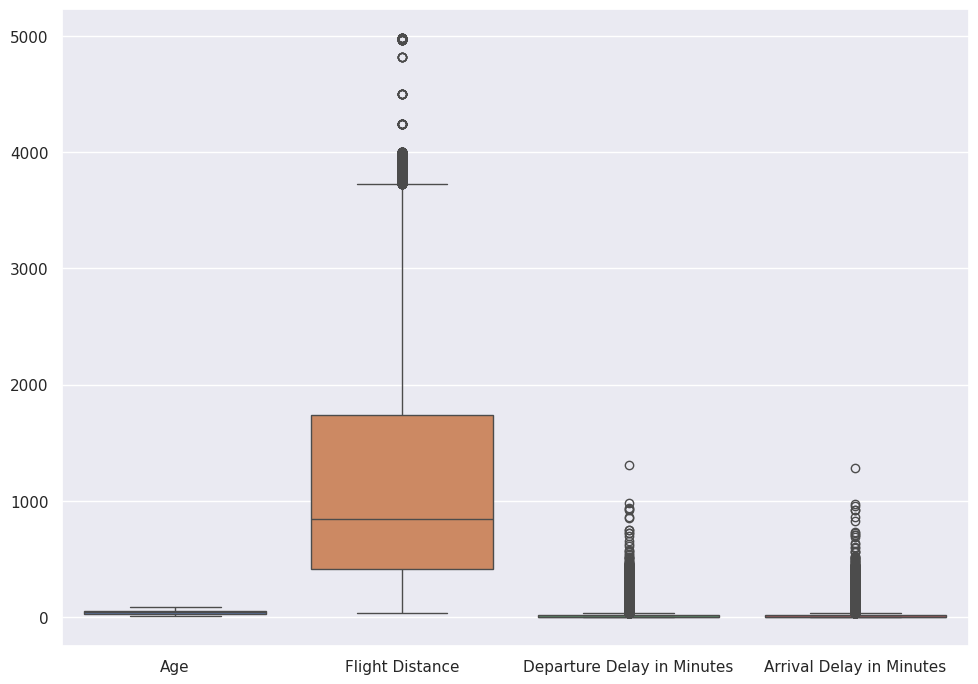

In [34]:
train_df.reset_index(drop=True, inplace=True)

cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

sns.boxplot(data=train_df[cols])

Original DataFrame Shape: (77928, 23)
DataFrame Shape after Removing Outliers: (76208, 23)
Columns with z-score > 3:  ['Age', 'Flight Distance', 'Departure Delay in Minutes']


<Axes: >

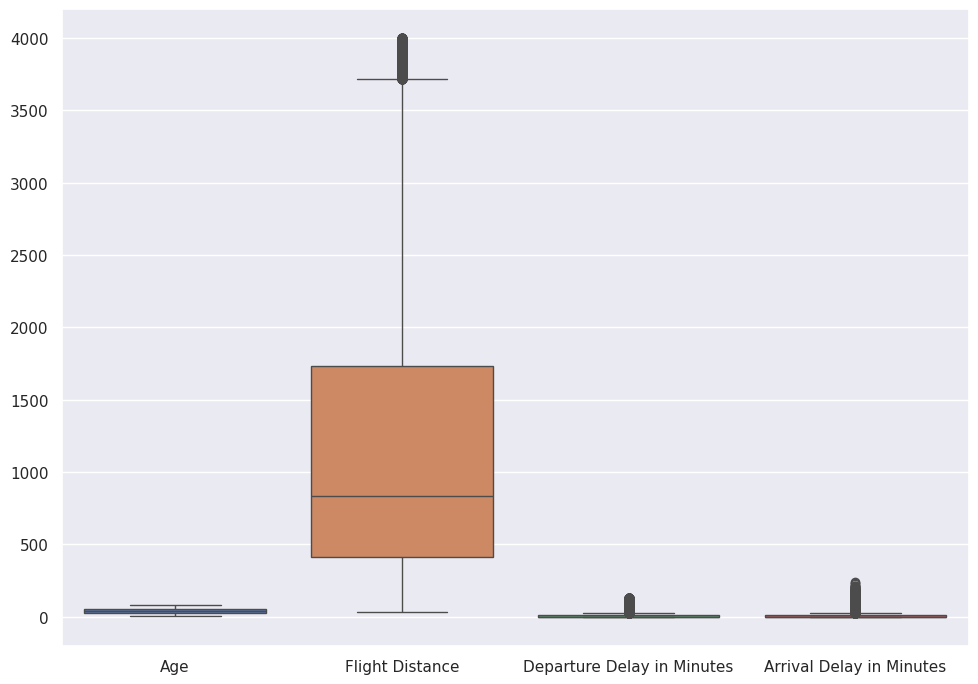

In [35]:
print("Original DataFrame Shape:", train_df.shape)
z_score_col = []
for cl in cols:
    z = np.abs(stats.zscore(train_df[cl]))
    outlier_set = (np.where(z > 3)[0])
    train_df = train_df.drop(index=outlier_set)
    train_df.reset_index(drop=True, inplace=True)
    if len(outlier_set > 0):
        z_score_col.append(cl)


print("DataFrame Shape after Removing Outliers:", train_df.shape)
print('Columns with z-score > 3: ', z_score_col)

sns.boxplot(data=train_df[cols])

## Enconding

### Class Variable

In [36]:
classes_dict = {
    'neutral or dissatisfied': 0,
    'satisfied': 1
}
def ord_encode(x):
    return classes_dict[x]

dec_class = 'satisfaction'
print('Before Encoding: ', train_df[dec_class].values)
train_df[dec_class] = train_df[dec_class].map(ord_encode)
validation_df[dec_class] = validation_df[dec_class].map(ord_encode)
print('After Encoding: ', train_df[dec_class].values)


Before Encoding:  ['neutral or dissatisfied' 'neutral or dissatisfied' 'satisfied' ...
 'satisfied' 'satisfied' 'satisfied']
After Encoding:  [0 0 1 ... 1 1 1]


### One Hot Enconding

In [37]:
one_hot_encoder_vars = ['Type of Travel', 'Gender', 'Customer Type']
validation_df = pd.get_dummies(validation_df, columns=one_hot_encoder_vars, drop_first=True)
train_df = pd.get_dummies(train_df, columns=one_hot_encoder_vars, drop_first=True)
train_df[['Type of Travel_Personal Travel', 'Gender_Male',  'Customer Type_disloyal Customer']]

,Type of Travel_Personal Travel,Gender_Male,Customer Type_disloyal Customer
0,False,False,True
1,True,True,False
2,False,True,False
3,False,False,False
4,True,False,False
...,...,...,...
76203,False,False,True
76204,False,True,False
76205,False,True,False
76206,False,True,True


### Ordinal Enconding

In [38]:
classes_dict = {
    'Eco': 0,
    'Eco Plus': 1,
    'Business': 2
}
def ord_encode(x):
    return classes_dict[x]

ordinal_encoder_vars = ['Class']
print('Before Encoding: ', train_df[ordinal_encoder_vars].values)
train_df[ordinal_encoder_vars] = train_df[ordinal_encoder_vars].applymap(ord_encode)
validation_df[ordinal_encoder_vars] = validation_df[ordinal_encoder_vars].applymap(ord_encode)
print('After Encoding: ', train_df[ordinal_encoder_vars].values)

Before Encoding:  [['Eco']
 ['Business']
 ['Business']
 ...
 ['Eco']
 ['Eco']
 ['Eco']]
After Encoding:  [[0]
 [2]
 [2]
 ...
 [0]
 [0]
 [0]]


## Correlation

### Continuous Variables

Needs to be done before Binning

<Axes: >

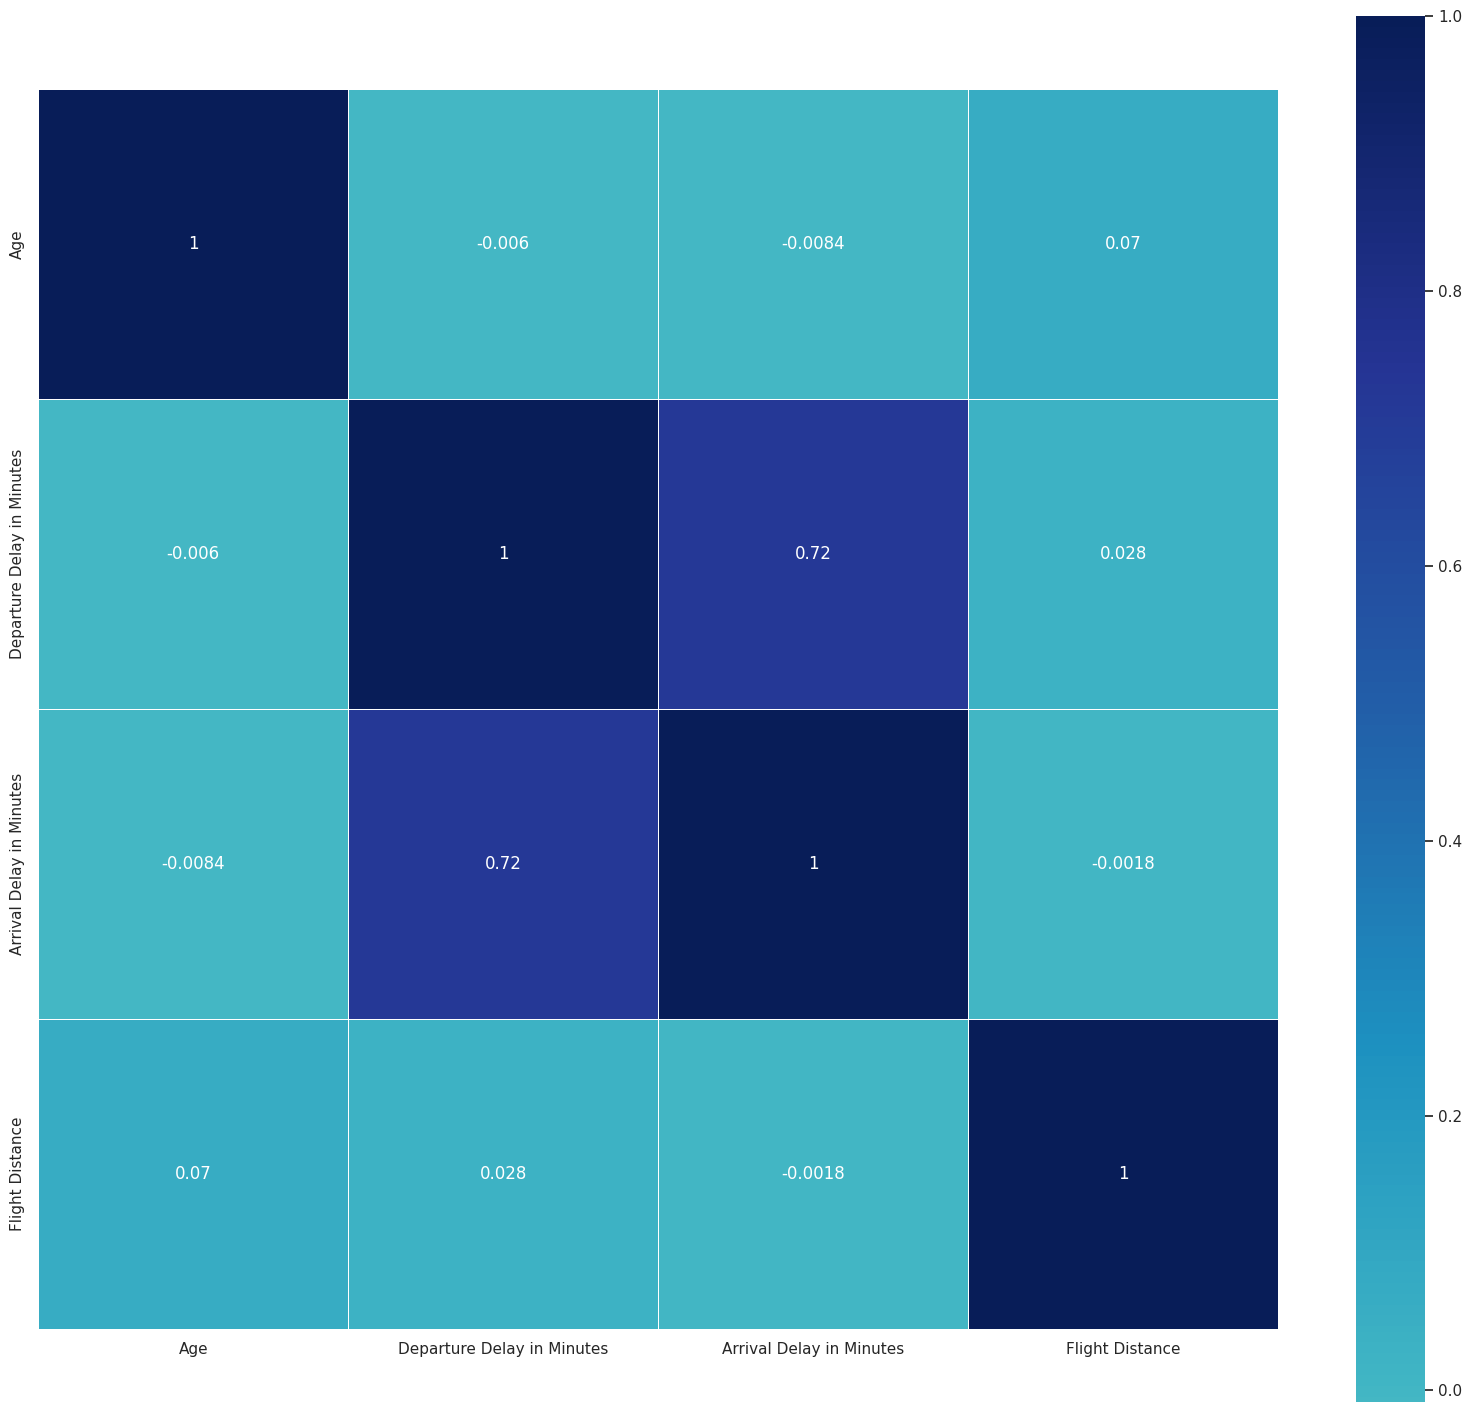

In [39]:
columns = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']

corr = train_df[columns].corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, cmap="YlGnBu", center=0,
           square=True, linewidths=.5)

In [40]:
corr

,Age,Departure Delay in Minutes,Arrival Delay in Minutes,Flight Distance
Age,1.000000,-0.006004,-0.008403,0.070058
Departure Delay in Minutes,-0.006004,1.000000,0.720268,0.028188
Arrival Delay in Minutes,-0.008403,0.720268,1.000000,-0.001753
Flight Distance,0.070058,0.028188,-0.001753,1.000000


### Categorical Variables (Chi Squared Test)

In [41]:
columns = ['Class', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'satisfaction', 'Type of Travel_Personal Travel', 'Gender_Male',
       'Customer Type_disloyal Customer']

print('Shape Before dropna: ', train_df[columns].shape)
df_corr = train_df[columns].dropna()
print('Shape After dropna: ', df_corr.shape)

cat_var_prod = list(product(columns,columns, repeat = 1))

result = []
for i in cat_var_prod:
       if i[0] != i[1]:
              result.append((i[0],i[1],list(stats.chi2_contingency(pd.crosstab(df_corr[i[0]], df_corr[i[1]])))[1]))
result

Shape Before dropna:  (76208, 19)
Shape After dropna:  (76208, 19)


[('Class', 'Inflight wifi service', 0.0),
 ('Class', 'Departure/Arrival time convenient', 0.0),
 ('Class', 'Ease of Online booking', 0.0),
 ('Class', 'Gate location', 0.0),
 ('Class', 'Food and drink', 1.931703496368308e-182),
 ('Class', 'Online boarding', 0.0),
 ('Class', 'Seat comfort', 0.0),
 ('Class', 'Inflight entertainment', 0.0),
 ('Class', 'On-board service', 0.0),
 ('Class', 'Leg room service', 0.0),
 ('Class', 'Baggage handling', 0.0),
 ('Class', 'Checkin service', 0.0),
 ('Class', 'Inflight service', 0.0),
 ('Class', 'Cleanliness', 0.0),
 ('Class', 'satisfaction', 0.0),
 ('Class', 'Type of Travel_Personal Travel', 0.0),
 ('Class', 'Gender_Male', 0.00022195924188573928),
 ('Class', 'Customer Type_disloyal Customer', 1.1749167208542276e-259),
 ('Inflight wifi service', 'Class', 0.0),
 ('Inflight wifi service', 'Departure/Arrival time convenient', 0.0),
 ('Inflight wifi service', 'Ease of Online booking', 0.0),
 ('Inflight wifi service', 'Gate location', 0.0),
 ('Inflight wifi 

<Axes: >

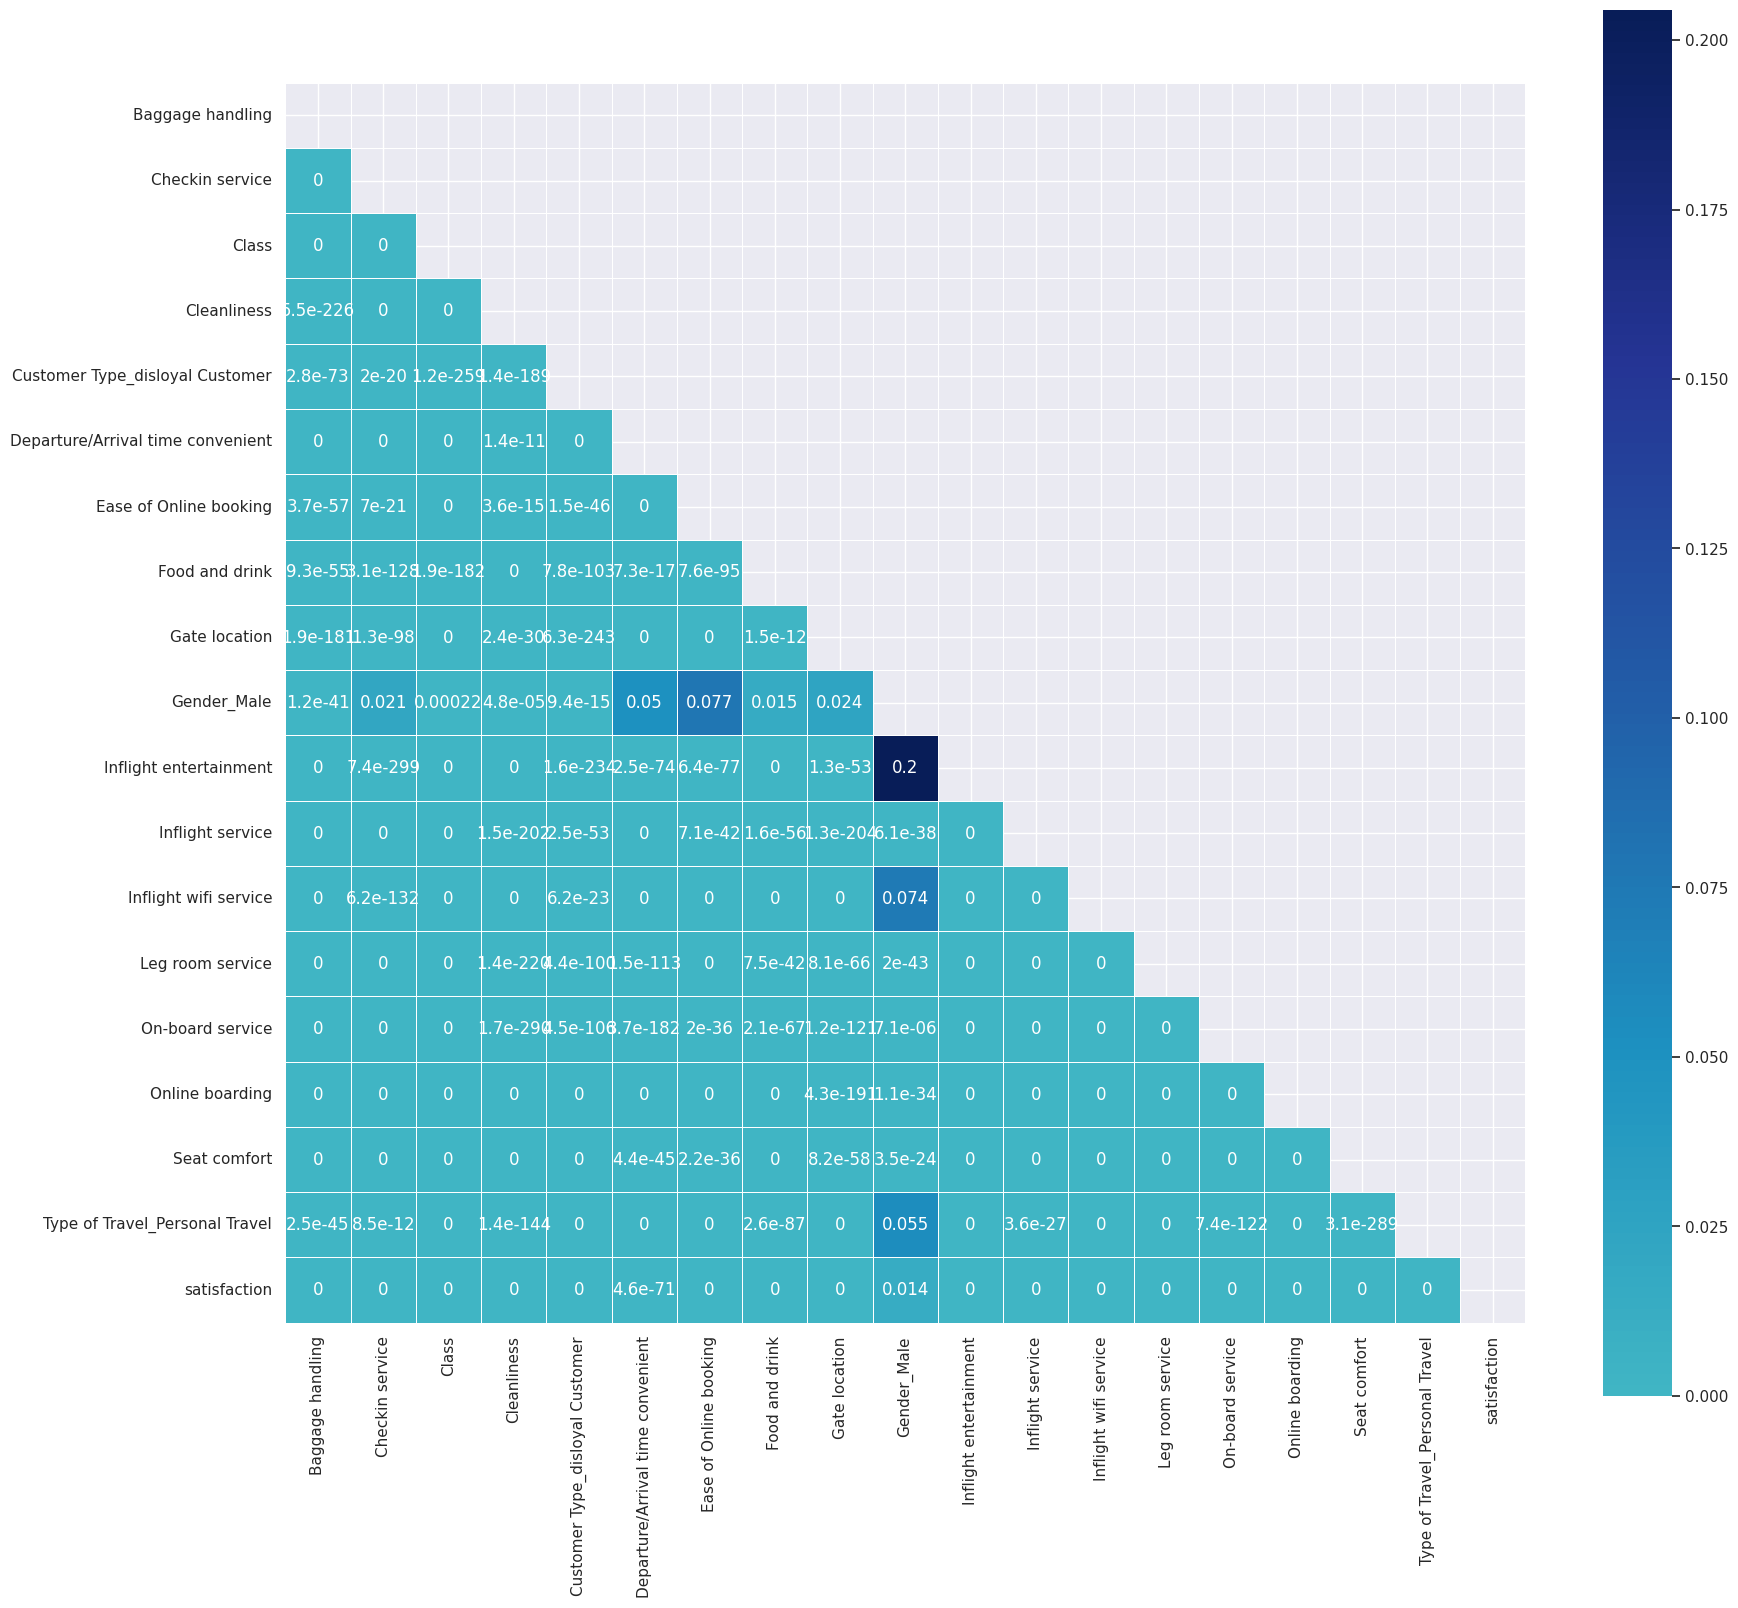

In [42]:
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2',
                                                       'corr'])

chi_test_output = chi_test_output.pivot(index='var1', columns='var2', values='corr')
chi_test_output =  chi_test_output.rename_axis(None, axis=1)
chi_test_output =  chi_test_output.rename_axis(None, axis=0)

# Generate a mask for the upper triangle
mask = np.zeros_like(chi_test_output, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(chi_test_output, annot = True, mask=mask, cmap="YlGnBu", center=0,
           square=True, linewidths=.5)


## Binning

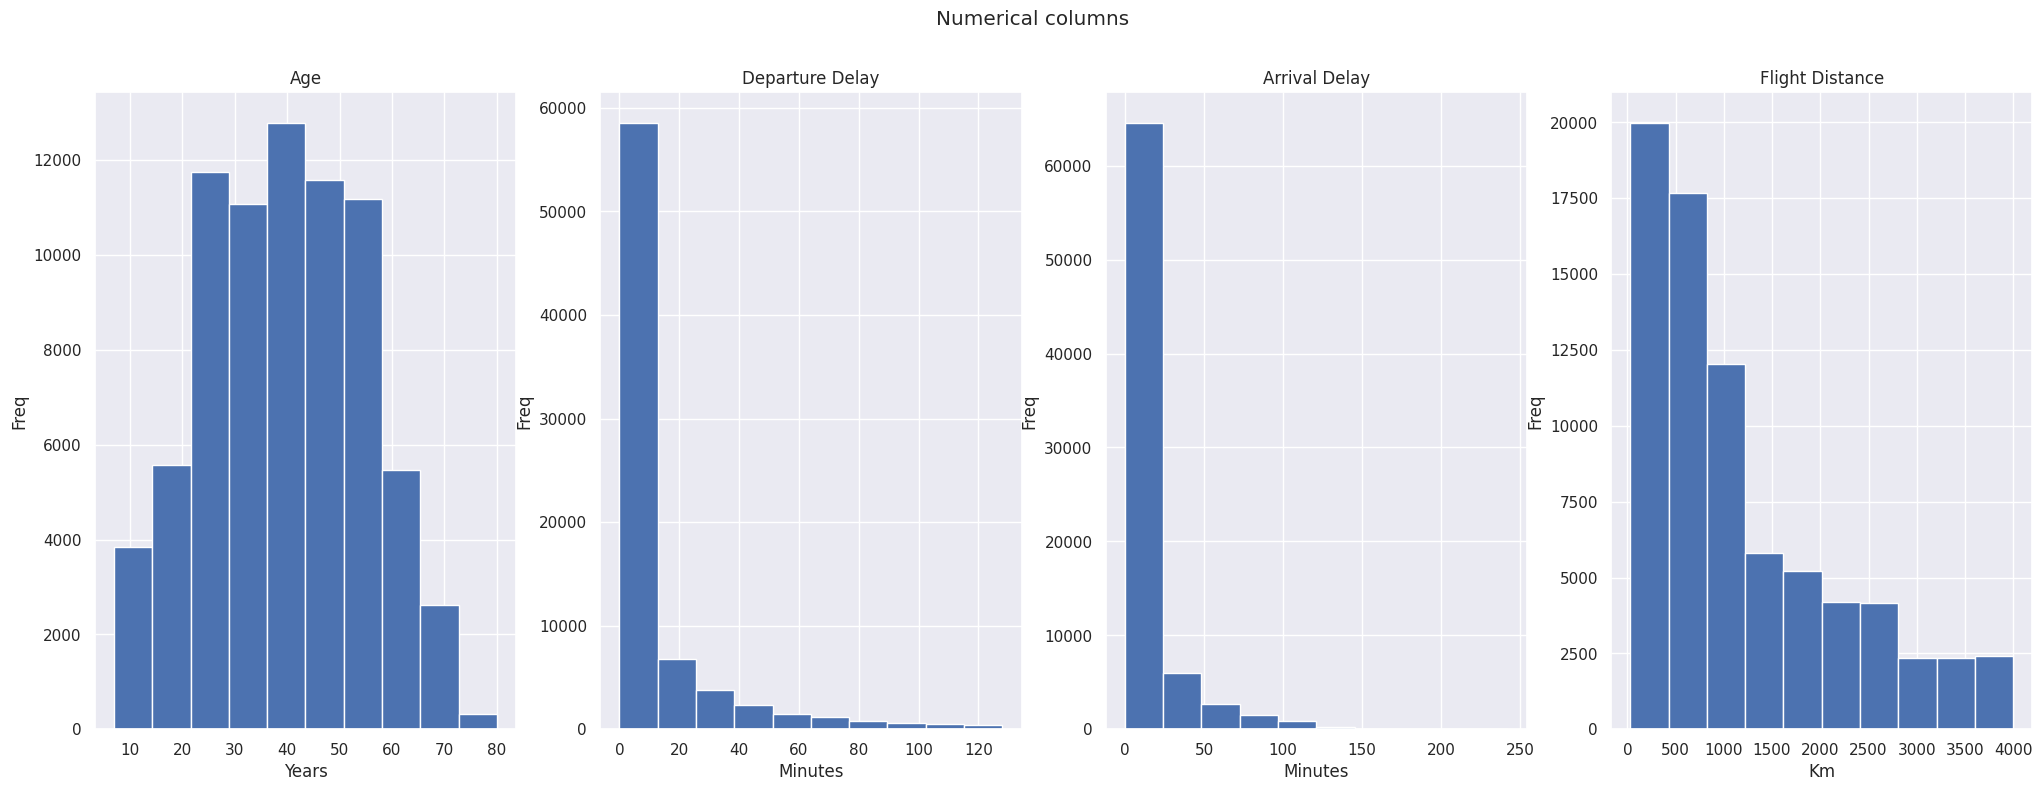

In [43]:
binning_vars = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

fig.set_figwidth(25)
fig.suptitle('Numerical columns')

ax1.set_title('Age')
ax1.set(xlabel='Years', ylabel='Freq')
ax1.hist(train_df['Age'])

ax2.set_title('Departure Delay')
ax2.set(xlabel='Minutes', ylabel='Freq')
ax2.hist(train_df['Departure Delay in Minutes'])

ax3.set_title('Arrival Delay')
ax3.set(xlabel='Minutes', ylabel='Freq')
ax3.hist(train_df['Arrival Delay in Minutes'])

ax4.set_title('Flight Distance')
ax4.set(xlabel='Km', ylabel='Freq')
ax4.hist(train_df['Flight Distance'])

plt.show()

In [44]:
def dist_binning(column: str):
    # 4 bins
    boundary = math.ceil((train_df[column].max()- train_df[column].min())/4)

    print(f'{column} boundary to split: ', boundary)

    bins_means = [math.ceil(train_df[(train_df[column] >= boundary*i) & (train_df[column] < boundary*(i+1))][column].mean()) for i in range(4)]
    print('Bin means: ', bins_means)

    def binnign_method(age) -> int:

        if np.isnan(age):
            return np.nan

        if age < boundary:
            return bins_means[0]

        if age < 2*boundary:
            return bins_means[1]

        if age < 3*boundary:
            return bins_means[2]

        if age < 4*boundary:
            return bins_means[3]

    print(f'{column} before binning: ', train_df[column].head(10))
    train_df[column] = train_df[column].map(binnign_method)
    validation_df[column] = validation_df[column].map(binnign_method)
    print(f'{column} After binning: ', train_df[column].head(10))


### Age

In [45]:
dist_binning(column='Age')

Age boundary to split:  19
Bin means:  [14, 29, 47, 63]
Age before binning:  0    55
1    24
2    45
3    59
4    56
5    41
6    26
7    37
8    47
9    44
Name: Age, dtype: int64
Age After binning:  0    47.0
1    29.0
2    47.0
3    63.0
4    47.0
5    47.0
6    29.0
7    29.0
8    47.0
9    47.0
Name: Age, dtype: float64


### Departure Delay

In [46]:
dist_binning(column='Departure Delay in Minutes')

Departure Delay in Minutes boundary to split:  32
Bin means:  [4, 45, 78, 111]
Departure Delay in Minutes before binning:  0     0
1     0
2    70
3     0
4     0
5     0
6     0
7    20
8     0
9     0
Name: Departure Delay in Minutes, dtype: int64
Departure Delay in Minutes After binning:  0     4.0
1     4.0
2    78.0
3     4.0
4     4.0
5     4.0
6     4.0
7     4.0
8     4.0
9     4.0
Name: Departure Delay in Minutes, dtype: float64


### Arrival Delay

In [47]:
dist_binning(column='Arrival Delay in Minutes')

Arrival Delay in Minutes boundary to split:  61
Bin means:  [7, 84, 138, 204]
Arrival Delay in Minutes before binning:  0     0.0
1     0.0
2    89.0
3     0.0
4     0.0
5     0.0
6     6.0
7     4.0
8     6.0
9     0.0
Name: Arrival Delay in Minutes, dtype: float64
Arrival Delay in Minutes After binning:  0     7.0
1     7.0
2    84.0
3     7.0
4     7.0
5     7.0
6     7.0
7     7.0
8     7.0
9     7.0
Name: Arrival Delay in Minutes, dtype: float64


### Flight Distance

In [48]:
dist_binning(column='Flight Distance')

Flight Distance boundary to split:  993
Bin means:  [497, 1425, 2439, 3480]
Flight Distance before binning:  0      78
1     102
2     488
3     547
4     163
5    1062
6     657
7    1874
8     386
9    2454
Name: Flight Distance, dtype: int64
Flight Distance After binning:  0     497.0
1     497.0
2     497.0
3     497.0
4     497.0
5    1425.0
6     497.0
7    1425.0
8     497.0
9    2439.0
Name: Flight Distance, dtype: float64


In [49]:
train_df.describe()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,76000.000000,76208.000000,76028.000000,76208.000000,76208.000000,76208.000000,76208.000000,76208.000000,76208.000000,76208.000000,76208.000000,76208.000000,76208.000000,76208.000000,76208.000000,76208.000000,76208.000000,76184.000000,75992.000000,76208.000000
mean,39.959618,1.025758,1177.255748,2.731852,3.060387,2.757309,2.977483,3.205385,3.250394,3.442631,3.358729,3.384382,3.341460,3.627231,3.307159,3.648593,3.285023,10.731571,11.159425,0.434692
std,14.054323,0.963221,946.518189,1.329915,1.526269,1.398343,1.276755,1.328464,1.349867,1.318160,1.334730,1.289274,1.320107,1.184449,1.264303,1.173212,1.311578,20.190872,18.407410,0.495720
min,14.000000,0.000000,497.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4.000000,7.000000,0.000000
25%,29.000000,0.000000,497.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,4.000000,7.000000,0.000000
50%,47.000000,1.000000,497.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,4.000000,7.000000,0.000000
75%,47.000000,2.000000,1425.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,4.000000,7.000000,1.000000
max,63.000000,2.000000,3480.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,111.000000,204.000000,1.000000


## Missing Values

In [50]:
# sns.heatmap(train_df.isnull(), cbar=False)
print(train_df.columns[train_df.isnull().any()])
columns = train_df.columns[train_df.isnull().any()]
train_df[columns] = train_df[columns].fillna(train_df[columns].median())
print(train_df.columns[train_df.isnull().any()])

Index(['Age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes'],
      dtype='object')
Index([], dtype='object')


In [51]:
# sns.heatmap(validation_df.isnull(), cbar=False)
print(validation_df.columns[validation_df.isnull().any()])
columns = validation_df.columns[validation_df.isnull().any()]

#substituindo pela mediana do conjunto de teste
validation_df[columns] = validation_df[columns].fillna(train_df[columns].median())
validation_df.columns[validation_df.isnull().any()]

Index(['Age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes'],
      dtype='object')


Index([], dtype='object')

## Min Max Scaling

In [52]:
columns = ['Age', 'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

scaler = MinMaxScaler()
f_scaler=scaler.fit(train_df[columns])

# Train
train_df[columns] = f_scaler.transform(train_df[columns])

# Validation
validation_df[columns] = f_scaler.transform(validation_df[columns])

## OverSampling

In [53]:
def overSampling(x, y):
  ros = RandomOverSampler(
    sampling_strategy='auto',
    random_state=0,
  )
  return ros.fit_resample(x,y)

def printClassDistributionRate(y):
  print('total: ',len(y))
  print('satisfied: ', len(y[y['satisfaction'] == 1]), ' not satisfied: ', len(y[y['satisfaction'] != 1]))
  print('satisfied: {:.2f}%'.format(len(y[y['satisfaction'] == 1])/len(y) * 100), ' not satisfied: {:.2f}%'.format(len(y[y['satisfaction'] != 1])/len(y) * 100), '\n')

In [54]:
x_train_df = train_df.drop(columns='satisfaction')
y_train_df = train_df[['satisfaction']]

printClassDistributionRate(y_train_df)

x_train_df, y_train_df = overSampling(x_train_df, y_train_df )

printClassDistributionRate(y_train_df)

total:  76208
satisfied:  33127  not satisfied:  43081
satisfied: 43.47%  not satisfied: 56.53% 

total:  86162
satisfied:  43081  not satisfied:  43081
satisfied: 50.00%  not satisfied: 50.00% 



In [55]:
x_validation_df = validation_df.drop(columns='satisfaction')
y_validation_df = validation_df[['satisfaction']]

printClassDistributionRate(y_validation_df)

x_validation_df, y_validation_df = overSampling(x_validation_df, y_validation_df )

printClassDistributionRate(y_validation_df)

total:  25976
satisfied:  11256  not satisfied:  14720
satisfied: 43.33%  not satisfied: 56.67% 

total:  29440
satisfied:  14720  not satisfied:  14720
satisfied: 50.00%  not satisfied: 50.00% 



# Experimento com Modelos

In [56]:
X_train, _, y_train, _ = train_test_split(x_train_df, y_train_df, test_size=0.90, stratify=y_train_df['satisfaction'])
X_valid, _, y_valid, _ = train_test_split(x_validation_df, y_validation_df, test_size=0.90, stratify=y_validation_df['satisfaction'])


# X_train, y_train = x_train_df, y_train_df
# X_valid, y_valid = x_validation_df, y_validation_df

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((8616, 22), (8616, 1), (2944, 22), (2944, 1))

In [57]:
def plot_confusion(y_true, y_pred, title):
 disp = ConfusionMatrixDisplay.from_predictions(
 y_true,
 y_pred,
 cmap=plt.cm.Blues,
 normalize=None,
 )
 disp.ax_.set_title(title)
 plt.show()

def cm(label_test, predicted_test, class_labels, title, normalize='pred'):
  matrix = confusion_matrix(label_test, predicted_test, normalize=normalize)
  disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = class_labels)
  disp.ax_.set_title(title)
  fig, ax = plt.subplots(figsize=(10,10))
  disp.plot(ax = ax)
  plt.show()

def kscurve(label_test, predicted_test, title):
  plot_ks_statistic(label_test, predicted_test, title=title)
  plt.show()

def plotRocCurve(label_test, predicted_test, title):
  fpr, tpr, _ = roc_curve(label_test, predicted_test)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.suptitle('Receiver Operating Characteristic (ROC) Curve')
  plt.title(title)
  plt.legend(loc='lower right')
  plt.show()



In [58]:
BATCH_SIZE = 128
EPOCHS = 20000

## MLP - Keras

In [ ]:
class MPL():
  def __init__(self, in_shape, out_shape, hidden_layers, activation, dropout, optmizer, lr, regularization, patience) -> None:
    self.model = Sequential()

    self.model.add(keras.Input(shape=in_shape))
    for layer in hidden_layers:
      self.model.add(Dense(layer, activation=activation, activity_regularizer=regularizers.L2(regularization)))
      self.model.add(Dropout(dropout))


    self.model.add(Dense(out_shape, activation=activation))

    self.model.summary()

    self.early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)

    self.opt = optmizer(learning_rate=lr)

  def __del__(self):
    del self.model

  def train(self, X_train, y_train, X_validation, y_validation, batch_size, epochs):
    self.model.compile(loss="sparse_categorical_crossentropy", optimizer=self.opt, metrics=['accuracy'])
    return self.model.fit(X_train, y_train, validation_data = (X_validation, y_validation), batch_size = batch_size, epochs = epochs, shuffle = True, callbacks=[self.early_stop_callback], verbose=0)

  def evaluate(self, X, y):
    loss, accuracy = self.model.evaluate(X, y)
    print('Loss:', loss)
    print('Accuracy:', accuracy)
    return loss, accuracy

  def predict(self, x):
    return self.model.predict(x)

In [66]:
def plot_train_history(history):
  pd.DataFrame(history.history).plot()
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

PARAMETROS: F.Act.: softmax; Layers: [10, 5]; LR: 0.1; Dropout: 0; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9290 - loss: 0.2946
Loss: 0.2883771061897278
Accuracy: 0.9307065010070801
SCORES: acc: 0.9307065010070801, loss: 0.2883771061897278

PARAMETROS: F.Act.: softmax; Layers: [10, 5]; LR: 0.1; Dropout: 0.1; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9254 - loss: 0.3269
Loss: 0.3190096616744995
Accuracy: 0.9256114363670349
SCORES: acc: 0.9256114363670349, loss: 0.3190096616744995

PARAMETROS: F.Act.: softmax; Layers: [10, 5]; LR: 0.01; Dropout: 0; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9324 - loss: 0.2838
Loss: 0.27682486176490784
Accuracy: 0.93410325050354
SCORES: acc: 0.93410325050354, loss: 0.27682486176490784

PARAMETROS: F.Act.: softmax; Layers: [10, 5]; LR: 0.01; Dropout: 0.1; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9304 - loss: 0.3237
Loss: 0.315865695476532
Accuracy: 0.9317255616188049
SCORES: acc: 0.9317255616188049, loss: 0.315865695476532

PARAMETROS: F.Act.: softmax; Layers: [50, 25, 10]; LR: 0.1; Dropout: 0; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9403 - loss: 0.2268
Loss: 0.21830202639102936
Accuracy: 0.942255437374115
SCORES: acc: 0.942255437374115, loss: 0.21830202639102936

PARAMETROS: F.Act.: softmax; Layers: [50, 25, 10]; LR: 0.1; Dropout: 0.1; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9210 - loss: 0.3069
Loss: 0.2968581020832062
Accuracy: 0.921875
SCORES: acc: 0.921875, loss: 0.2968581020832062

PARAMETROS: F.Act.: softmax; Layers: [50, 25, 10]; LR: 0.01; Dropout: 0; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9447 - loss: 0.1940
Loss: 0.1853988617658615
Accuracy: 0.94870924949646
SCORES: acc: 0.94870924949646, loss: 0.1853988617658615

PARAMETROS: F.Act.: softmax; Layers: [50, 25, 10]; LR: 0.01; Dropout: 0.1; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9419 - loss: 0.2244
Loss: 0.21362800896167755
Accuracy: 0.944972813129425
SCORES: acc: 0.944972813129425, loss: 0.21362800896167755

PARAMETROS: F.Act.: softmax; Layers: [50, 50, 50]; LR: 0.1; Dropout: 0; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,352 (24.81 KB)

 Trainable params: 6,352 (24.81 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9168 - loss: 0.2811
Loss: 0.27115780115127563
Accuracy: 0.9191576242446899
SCORES: acc: 0.9191576242446899, loss: 0.27115780115127563

PARAMETROS: F.Act.: softmax; Layers: [50, 50, 50]; LR: 0.1; Dropout: 0.1; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,352 (24.81 KB)

 Trainable params: 6,352 (24.81 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9308 - loss: 0.2204
Loss: 0.2072400450706482
Accuracy: 0.9351223111152649
SCORES: acc: 0.9351223111152649, loss: 0.2072400450706482

PARAMETROS: F.Act.: softmax; Layers: [50, 50, 50]; LR: 0.01; Dropout: 0; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,352 (24.81 KB)

 Trainable params: 6,352 (24.81 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5065 - loss: 0.7123
Loss: 0.7123563885688782
Accuracy: 0.5
SCORES: acc: 0.5, loss: 0.7123563885688782

PARAMETROS: F.Act.: softmax; Layers: [50, 50, 50]; LR: 0.01; Dropout: 0.1; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,352 (24.81 KB)

 Trainable params: 6,352 (24.81 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5065 - loss: 0.7123
Loss: 0.7123592495918274
Accuracy: 0.5
SCORES: acc: 0.5, loss: 0.7123592495918274



Best model args: PARAMETROS: F.Act.: softmax; Layers: [50, 25, 10]; LR: 0.01; Dropout: 0; Reg: 0.01


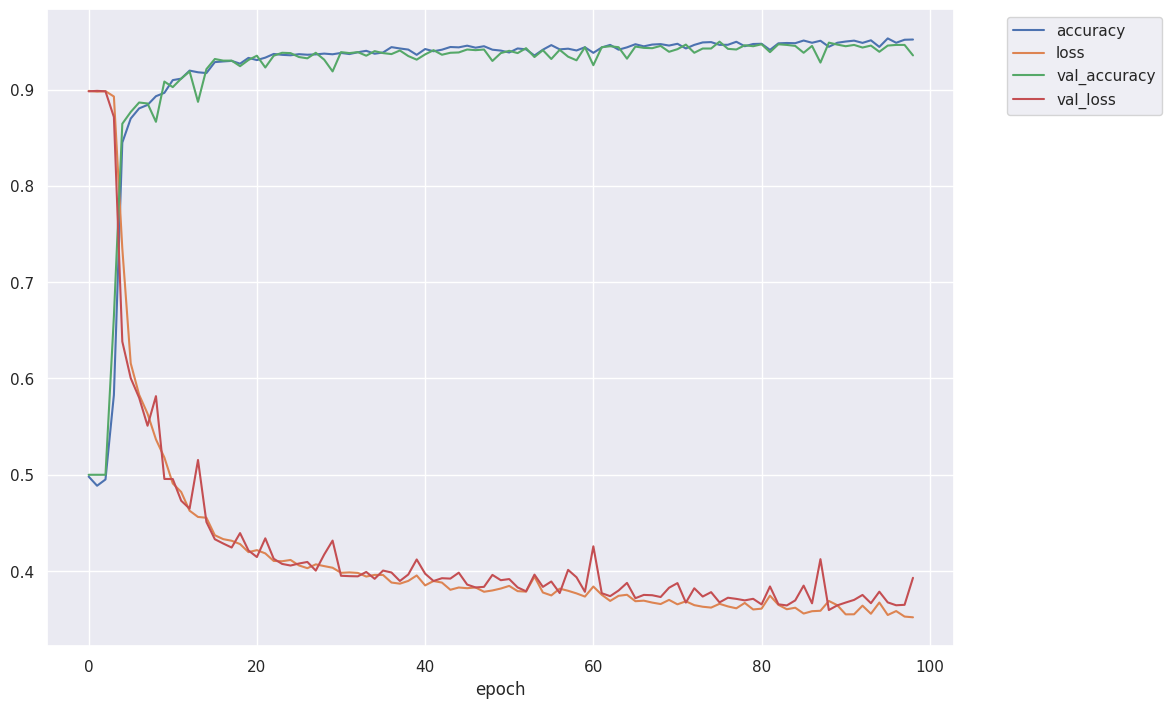

In [ ]:
def grid_search(X_t, y_t, X_v, y_v, activation_fn, hidden_layers, learning_rate, dropout, regularization):
  best_acc = 0
  best_model = None
  best_hist = None
  args = None

  for act in activation_fn:
    for hl in hidden_layers:
      for lr in learning_rate:
        for drp in dropout:
          for reg in regularization:
            print(f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}')
            tf.keras.backend.clear_session()
            model = MPL(in_shape=(22,), out_shape=2, hidden_layers=hl, activation=act, dropout=drp, optmizer=optimizers.Adam, lr=lr, regularization=reg, patience=10)
            history = model.train(X_t, y_t, X_v, y_v, batch_size=BATCH_SIZE, epochs=EPOCHS)
            loss, acc = model.evaluate(X_v, y_v)
            if acc > best_acc:
                best_acc = acc
                best_model = model
                best_hist = history
                args = f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}'
            print(f'SCORES: acc: {acc}, loss: {loss}\n')
            del model
            del history
  print(f"\n\nBest model args: {args}")
  return best_model, best_hist, args

X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32')
X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32')

hidden_channels = [[10, 5], [50, 25, 10], [50, 50, 50]]
# actv_fns = ['sigmoid', 'relu', 'tanh','softmax']
actv_fns = ['softmax']
learning_rates = [0.1, 0.01]
dropout = [0, 0.1]
regularization = [0.01]
# regularization = [0, 0.01]

# hidden_channels = [[10, 5]]
# actv_fns = ['softmax']
# learning_rates = [0.01]
# dropout = [0]
# regularization = [0.01]

best_model, best_hist, args = grid_search(X_t, y_t, X_v, y_v, actv_fns, hidden_channels, learning_rates, dropout, regularization)
plot_train_history(best_hist)

In [ ]:
best_model.evaluate(X_v, y_v)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9447 - loss: 0.1940
Loss: 0.1853988617658615
Accuracy: 0.94870924949646


(0.1853988617658615, 0.94870924949646)

In [ ]:
best_model.evaluate(X_v, y_v)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9447 - loss: 0.1940
Loss: 0.1853988617658615
Accuracy: 0.94870924949646


(0.1853988617658615, 0.94870924949646)

In [ ]:
y_pred = best_model.predict(X_v)
y_pred
plot_confusion(y_v, y_pred, 'Best Model')


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
type(y_pred)

numpy.ndarray

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


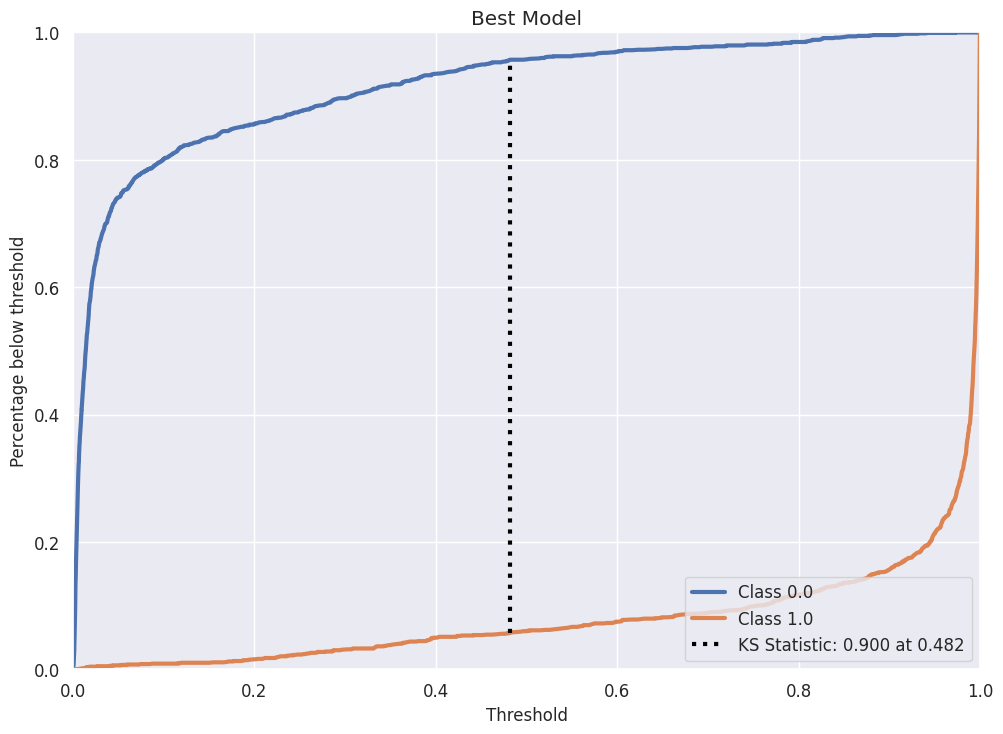

In [ ]:
kscurve(y_v, y_pred, 'Best Model')

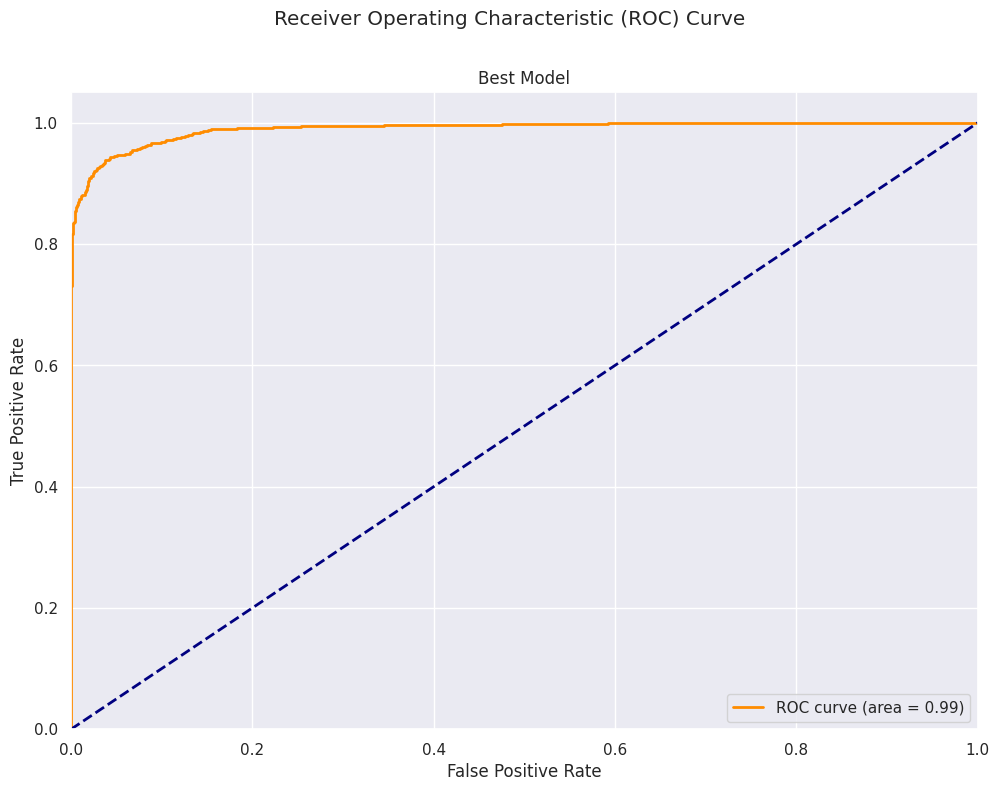

In [ ]:
plotRocCurve(y_v, y_pred[:, 1], 'Best Model')

## MLP - Keras c/ Optuna

In [ ]:
class MPL():
  def __init__(self, in_shape, out_shape, hidden_layers, activation, dropout, optmizer, lr, regularization, patience) -> None:
    self.model = Sequential()

    self.model.add(keras.Input(shape=in_shape))
    for layer in hidden_layers:
      self.model.add(Dense(layer, activation=activation, activity_regularizer=regularizers.L2(regularization)))
      self.model.add(Dropout(dropout))


    self.model.add(Dense(out_shape, activation=activation))

    self.model.summary()

    self.early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)

    self.opt = optmizer(learning_rate=lr)

  def __del__(self):
    del self.model

  def train(self, X_train, y_train, X_validation, y_validation, batch_size, epochs):
    self.model.compile(loss="sparse_categorical_crossentropy", optimizer=self.opt, metrics=['accuracy'])
    return self.model.fit(X_train, y_train, validation_data = (X_validation, y_validation), batch_size = batch_size, epochs = epochs, shuffle = True, callbacks=[self.early_stop_callback], verbose=0)

  def evaluate(self, X, y):
    loss, accuracy = self.model.evaluate(X, y)
    print('Loss:', loss)
    print('Accuracy:', accuracy)
    return loss, accuracy

  def predict(self, x):
    return self.model.predict(x)

In [ ]:
def plot_train_history(history):
  pd.DataFrame(history.history).plot()
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

In [ ]:
X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32')
X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32')

def objective(trial):

  hidden_channels = [[10, 5], [5, 10]]
  actv_fns = ['sigmoid', 'relu', 'tanh','softmax']
  learning_rates = [1e-2, 1e-1]
  dropout = [0, 0.1]
  regularization = [0, 1e-2]

  hl = trial.suggest_categorical('Hidden Channels', hidden_channels)
  act = trial.suggest_categorical('Activation Function', actv_fns)
  lr = trial.suggest_categorical('Learning rate', learning_rates)
  drp = trial.suggest_categorical('Dropout', dropout)
  reg = trial.suggest_categorical('Regularization', regularization)

  tf.keras.backend.clear_session()
  model = MPL(in_shape=(22,), out_shape=2, hidden_layers=hl, activation=act, dropout=drp, optmizer=optimizers.Adam, lr=lr, regularization=reg, patience=10)
  history = model.train(X_t, y_t, X_v, y_v, batch_size=BATCH_SIZE, epochs=EPOCHS)
  loss, acc = model.evaluate(X_v, y_v)

  trial.set_user_attr(key="model", value=(model, history))

  return loss

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["model"])

study = opt.create_study(direction = 'minimize')
study.optimize(objective, n_trials=100, callbacks=[callback])

best_model, best_hist = study.user_attrs['best_model']
plot_train_history(best_hist)

[I 2024-07-18 01:41:45,390] A new study created in memory with name: no-name-8e42133f-6d00-46d2-8e64-1656724d1e36
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [10, 5] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [5, 10] which is of type list.
  warnings.warn(message)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9428 - loss: 0.1574
Loss: 0.14412599802017212
Accuracy: 0.9429348111152649


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
[I 2024-07-18 01:42:18,478] Trial 0 finished with value: 0.14412599802017212 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8841 - loss: 0.3176
Loss: 0.29263028502464294
Accuracy: 0.8933423757553101


[I 2024-07-18 01:42:44,992] Trial 1 finished with value: 0.29263028502464294 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0.01}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4935 - loss: 0.6931
Loss: 0.6931466460227966
Accuracy: 0.5


[I 2024-07-18 01:43:12,060] Trial 2 finished with value: 0.6931466460227966 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'tanh', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9322 - loss: 0.1803
Loss: 0.16643404960632324
Accuracy: 0.9337635636329651


[I 2024-07-18 01:43:33,021] Trial 3 finished with value: 0.16643404960632324 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9158 - loss: 0.2040
Loss: 0.1958303451538086
Accuracy: 0.91745924949646


[I 2024-07-18 01:43:45,068] Trial 4 finished with value: 0.1958303451538086 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9317 - loss: 0.1689
Loss: 0.15923051536083221
Accuracy: 0.9324048757553101


[I 2024-07-18 01:44:32,354] Trial 5 finished with value: 0.15923051536083221 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9317 - loss: 0.1689
Loss: 0.15708887577056885
Accuracy: 0.9337635636329651


[I 2024-07-18 01:45:13,596] Trial 6 finished with value: 0.15708887577056885 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'softmax', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9019 - loss: 0.2413
Loss: 0.23559963703155518
Accuracy: 0.903192937374115


[I 2024-07-18 01:45:31,087] Trial 7 finished with value: 0.23559963703155518 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'softmax', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9253 - loss: 0.2964
Loss: 0.2877833843231201
Accuracy: 0.92629075050354


[I 2024-07-18 01:45:46,260] Trial 8 finished with value: 0.2877833843231201 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9340 - loss: 0.1745
Loss: 0.16582611203193665
Accuracy: 0.932744562625885


[I 2024-07-18 01:46:42,636] Trial 9 finished with value: 0.16582611203193665 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4935 - loss: 0.6931
Loss: 0.6931470036506653
Accuracy: 0.5


[I 2024-07-18 01:47:10,005] Trial 10 finished with value: 0.6931470036506653 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'relu', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4935 - loss: 0.6931
Loss: 0.6931466460227966
Accuracy: 0.5


[I 2024-07-18 01:47:20,819] Trial 11 finished with value: 0.6931466460227966 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'tanh', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4935 - loss: 0.6931
Loss: 0.6931466460227966
Accuracy: 0.5


[I 2024-07-18 01:47:30,842] Trial 12 finished with value: 0.6931466460227966 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'relu', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9309 - loss: 0.1698
Loss: 0.15640494227409363
Accuracy: 0.9354619383811951


[I 2024-07-18 01:48:01,607] Trial 13 finished with value: 0.15640494227409363 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9051 - loss: 0.2554
Loss: 0.23004113137722015
Accuracy: 0.9120244383811951


[I 2024-07-18 01:48:43,780] Trial 14 finished with value: 0.23004113137722015 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9351 - loss: 0.1543
Loss: 0.14479218423366547
Accuracy: 0.937839686870575


[I 2024-07-18 01:49:20,477] Trial 15 finished with value: 0.14479218423366547 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 0 with value: 0.14412599802017212.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9416 - loss: 0.1556
Loss: 0.14341628551483154
Accuracy: 0.9425951242446899


[I 2024-07-18 01:49:59,794] Trial 16 finished with value: 0.14341628551483154 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9334 - loss: 0.1647
Loss: 0.15285508334636688
Accuracy: 0.9354619383811951


[I 2024-07-18 01:50:37,935] Trial 17 finished with value: 0.15285508334636688 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8951 - loss: 0.2225
Loss: 0.20661930739879608
Accuracy: 0.90455162525177


[I 2024-07-18 01:52:28,820] Trial 18 finished with value: 0.20661930739879608 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4939 - loss: 0.6931
Loss: 0.6931466460227966
Accuracy: 0.4976222813129425


[I 2024-07-18 01:52:36,104] Trial 19 finished with value: 0.6931466460227966 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'tanh', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8844 - loss: 0.2884
Loss: 0.2874017357826233
Accuracy: 0.8868885636329651


[I 2024-07-18 01:52:48,284] Trial 20 finished with value: 0.2874017357826233 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'relu', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9347 - loss: 0.1683
Loss: 0.15994158387184143
Accuracy: 0.934442937374115


[I 2024-07-18 01:53:20,278] Trial 21 finished with value: 0.15994158387184143 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9391 - loss: 0.1540
Loss: 0.14397668838500977
Accuracy: 0.94089674949646


[I 2024-07-18 01:54:00,636] Trial 22 finished with value: 0.14397668838500977 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9338 - loss: 0.1693
Loss: 0.15582752227783203
Accuracy: 0.936141312122345


[I 2024-07-18 01:54:33,936] Trial 23 finished with value: 0.15582752227783203 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9393 - loss: 0.1554
Loss: 0.14683154225349426
Accuracy: 0.937839686870575


[I 2024-07-18 01:55:02,539] Trial 24 finished with value: 0.14683154225349426 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9278 - loss: 0.1762
Loss: 0.16102942824363708
Accuracy: 0.9324048757553101


[I 2024-07-18 01:55:46,079] Trial 25 finished with value: 0.16102942824363708 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9003 - loss: 0.2762
Loss: 0.2517596483230591
Accuracy: 0.9089673757553101


[I 2024-07-18 01:56:58,389] Trial 26 finished with value: 0.2517596483230591 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0.01}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8916 - loss: 0.2414
Loss: 0.2229403853416443
Accuracy: 0.9038723111152649


[I 2024-07-18 01:57:15,669] Trial 27 finished with value: 0.2229403853416443 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4935 - loss: 0.6931
Loss: 0.6931466460227966
Accuracy: 0.5


[I 2024-07-18 01:57:23,196] Trial 28 finished with value: 0.6931466460227966 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'tanh', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8867 - loss: 0.3056
Loss: 0.2792356610298157
Accuracy: 0.8977581262588501


[I 2024-07-18 01:57:51,740] Trial 29 finished with value: 0.2792356610298157 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0.01}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8252 - loss: 0.4236
Loss: 0.4098774492740631
Accuracy: 0.832880437374115


[I 2024-07-18 01:58:00,576] Trial 30 finished with value: 0.4098774492740631 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'relu', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9382 - loss: 0.1600
Loss: 0.1491151601076126
Accuracy: 0.9395380616188049


[I 2024-07-18 01:58:33,893] Trial 31 finished with value: 0.1491151601076126 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9388 - loss: 0.1561
Loss: 0.14365842938423157
Accuracy: 0.9432744383811951


[I 2024-07-18 01:59:14,511] Trial 32 finished with value: 0.14365842938423157 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9343 - loss: 0.1591
Loss: 0.1479099988937378
Accuracy: 0.9375


[I 2024-07-18 01:59:46,224] Trial 33 finished with value: 0.1479099988937378 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9353 - loss: 0.1525
Loss: 0.1478935182094574
Accuracy: 0.937160313129425


[I 2024-07-18 02:00:22,613] Trial 34 finished with value: 0.1478935182094574 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 16 with value: 0.14341628551483154.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9435 - loss: 0.1365
Loss: 0.1263161599636078
Accuracy: 0.945652186870575


[I 2024-07-18 02:00:38,376] Trial 35 finished with value: 0.1263161599636078 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9392 - loss: 0.1516
Loss: 0.1429133415222168
Accuracy: 0.9425951242446899


[I 2024-07-18 02:00:52,990] Trial 36 finished with value: 0.1429133415222168 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5065 - loss: 0.6931
Loss: 0.6931466460227966
Accuracy: 0.5


[I 2024-07-18 02:01:08,847] Trial 37 finished with value: 0.6931466460227966 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'tanh', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8715 - loss: 0.3213
Loss: 0.2940545380115509
Accuracy: 0.884171187877655


[I 2024-07-18 02:01:20,482] Trial 38 finished with value: 0.2940545380115509 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9338 - loss: 0.1616
Loss: 0.14934346079826355
Accuracy: 0.9364809989929199


[I 2024-07-18 02:01:44,662] Trial 39 finished with value: 0.14934346079826355 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9373 - loss: 0.1517
Loss: 0.1405768245458603
Accuracy: 0.9395380616188049


[I 2024-07-18 02:02:03,659] Trial 40 finished with value: 0.1405768245458603 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9328 - loss: 0.1753
Loss: 0.16596804559230804
Accuracy: 0.932744562625885


[I 2024-07-18 02:02:32,889] Trial 41 finished with value: 0.16596804559230804 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9352 - loss: 0.1571
Loss: 0.1488514095544815
Accuracy: 0.9354619383811951


[I 2024-07-18 02:02:56,469] Trial 42 finished with value: 0.1488514095544815 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9419 - loss: 0.1502
Loss: 0.14432527124881744
Accuracy: 0.9415760636329651


[I 2024-07-18 02:03:17,669] Trial 43 finished with value: 0.14432527124881744 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9050 - loss: 0.2324
Loss: 0.2109663039445877
Accuracy: 0.91236412525177


[I 2024-07-18 02:03:34,474] Trial 44 finished with value: 0.2109663039445877 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9338 - loss: 0.1583
Loss: 0.14748363196849823
Accuracy: 0.9368206262588501


[I 2024-07-18 02:03:59,529] Trial 45 finished with value: 0.14748363196849823 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4935 - loss: 0.6931
Loss: 0.6931466460227966
Accuracy: 0.5


[I 2024-07-18 02:04:14,851] Trial 46 finished with value: 0.6931466460227966 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'relu', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8843 - loss: 0.3099
Loss: 0.2810121178627014
Accuracy: 0.8974184989929199


[I 2024-07-18 02:04:32,662] Trial 47 finished with value: 0.2810121178627014 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9368 - loss: 0.1530
Loss: 0.14138588309288025
Accuracy: 0.940557062625885


[I 2024-07-18 02:04:49,423] Trial 48 finished with value: 0.14138588309288025 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9124 - loss: 0.1970
Loss: 0.18489804863929749
Accuracy: 0.91745924949646


[I 2024-07-18 02:05:04,390] Trial 49 finished with value: 0.18489804863929749 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4935 - loss: 0.6931
Loss: 0.6931422352790833
Accuracy: 0.5


[I 2024-07-18 02:05:19,331] Trial 50 finished with value: 0.6931422352790833 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'tanh', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9366 - loss: 0.1427
Loss: 0.13474147021770477
Accuracy: 0.94191575050354


[I 2024-07-18 02:05:33,005] Trial 51 finished with value: 0.13474147021770477 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9285 - loss: 0.1695
Loss: 0.15656666457653046
Accuracy: 0.932744562625885


[I 2024-07-18 02:05:50,115] Trial 52 finished with value: 0.15656666457653046 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9276 - loss: 0.1617
Loss: 0.1475529819726944
Accuracy: 0.932744562625885


[I 2024-07-18 02:06:02,053] Trial 53 finished with value: 0.1475529819726944 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9429 - loss: 0.1376
Loss: 0.12885184586048126
Accuracy: 0.94870924949646


[I 2024-07-18 02:06:21,646] Trial 54 finished with value: 0.12885184586048126 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9356 - loss: 0.1590
Loss: 0.1508025825023651
Accuracy: 0.94089674949646


[I 2024-07-18 02:06:38,858] Trial 55 finished with value: 0.1508025825023651 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9419 - loss: 0.1533
Loss: 0.14163659512996674
Accuracy: 0.9429348111152649


[I 2024-07-18 02:06:54,722] Trial 56 finished with value: 0.14163659512996674 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9345 - loss: 0.1563
Loss: 0.14434632658958435
Accuracy: 0.9351223111152649


[I 2024-07-18 02:07:09,139] Trial 57 finished with value: 0.14434632658958435 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4935 - loss: 0.6931
Loss: 0.6931466460227966
Accuracy: 0.5


[I 2024-07-18 02:07:20,932] Trial 58 finished with value: 0.6931466460227966 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'relu', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9336 - loss: 0.1664
Loss: 0.1509690135717392
Accuracy: 0.9368206262588501


[I 2024-07-18 02:07:35,502] Trial 59 finished with value: 0.1509690135717392 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.1390
Loss: 0.1328456550836563
Accuracy: 0.94361412525177


[I 2024-07-18 02:07:55,186] Trial 60 finished with value: 0.1328456550836563 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8890 - loss: 0.2759
Loss: 0.2501634955406189
Accuracy: 0.8974184989929199


[I 2024-07-18 02:08:13,639] Trial 61 finished with value: 0.2501634955406189 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9379 - loss: 0.1534
Loss: 0.14266037940979004
Accuracy: 0.9412364363670349


[I 2024-07-18 02:08:36,024] Trial 62 finished with value: 0.14266037940979004 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9396 - loss: 0.1435
Loss: 0.135212704539299
Accuracy: 0.94191575050354


[I 2024-07-18 02:08:52,389] Trial 63 finished with value: 0.135212704539299 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9388 - loss: 0.1366
Loss: 0.12833696603775024
Accuracy: 0.94191575050354


[I 2024-07-18 02:09:12,125] Trial 64 finished with value: 0.12833696603775024 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9365 - loss: 0.1540
Loss: 0.14224445819854736
Accuracy: 0.9402173757553101


[I 2024-07-18 02:09:25,636] Trial 65 finished with value: 0.14224445819854736 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9289 - loss: 0.1712
Loss: 0.15795043110847473
Accuracy: 0.9351223111152649


[I 2024-07-18 02:09:39,589] Trial 66 finished with value: 0.15795043110847473 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5141 - loss: 0.5548
Loss: 0.5536993741989136
Accuracy: 0.5084918737411499


[I 2024-07-18 02:09:48,313] Trial 67 finished with value: 0.5536993741989136 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'tanh', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9403 - loss: 0.1597
Loss: 0.14830057322978973
Accuracy: 0.9398776888847351


[I 2024-07-18 02:10:00,256] Trial 68 finished with value: 0.14830057322978973 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9034 - loss: 0.3766
Loss: 0.36240077018737793
Accuracy: 0.9103260636329651


[I 2024-07-18 02:10:17,153] Trial 69 finished with value: 0.36240077018737793 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0.01}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9396 - loss: 0.1472
Loss: 0.14031003415584564
Accuracy: 0.9385190010070801


[I 2024-07-18 02:10:32,489] Trial 70 finished with value: 0.14031003415584564 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9396 - loss: 0.1412
Loss: 0.13609834015369415
Accuracy: 0.94191575050354


[I 2024-07-18 02:10:53,992] Trial 71 finished with value: 0.13609834015369415 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9372 - loss: 0.1614
Loss: 0.14925536513328552
Accuracy: 0.937839686870575


[I 2024-07-18 02:11:17,224] Trial 72 finished with value: 0.14925536513328552 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9422 - loss: 0.1460
Loss: 0.1364937275648117
Accuracy: 0.9429348111152649


[I 2024-07-18 02:11:34,046] Trial 73 finished with value: 0.1364937275648117 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9335 - loss: 0.1534
Loss: 0.1448715776205063
Accuracy: 0.9375


[I 2024-07-18 02:11:52,115] Trial 74 finished with value: 0.1448715776205063 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9265 - loss: 0.1733
Loss: 0.16442488133907318
Accuracy: 0.9317255616188049


[I 2024-07-18 02:12:07,960] Trial 75 finished with value: 0.16442488133907318 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4935 - loss: 0.6931
Loss: 0.6931466460227966
Accuracy: 0.5


[I 2024-07-18 02:12:15,815] Trial 76 finished with value: 0.6931466460227966 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'relu', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9350 - loss: 0.1636
Loss: 0.14750029146671295
Accuracy: 0.9385190010070801


[I 2024-07-18 02:12:30,830] Trial 77 finished with value: 0.14750029146671295 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9368 - loss: 0.1427
Loss: 0.13447588682174683
Accuracy: 0.9398776888847351


[I 2024-07-18 02:12:52,263] Trial 78 finished with value: 0.13447588682174683 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9156 - loss: 0.2136
Loss: 0.20239749550819397
Accuracy: 0.920516312122345


[I 2024-07-18 02:13:14,042] Trial 79 finished with value: 0.20239749550819397 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9381 - loss: 0.1495
Loss: 0.1391686648130417
Accuracy: 0.9368206262588501


[I 2024-07-18 02:13:34,899] Trial 80 finished with value: 0.1391686648130417 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 35 with value: 0.1263161599636078.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
study.best_params

In [ ]:
best_model.evaluate(X_v, y_v)

In [ ]:
y_pred = best_model.predict(X_v)
y_pred
plot_confusion(y_v, y_pred, 'Best Model')

## RF - Keras

In [62]:
tuner = tfdf.tuner.RandomSearch(num_trials=100)
tuner.choice("max_depth", [16, 18, 20, 22, 24])

tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"])
tuner.choice("max_num_nodes", [16, 32, 64])
tuner.choice("num_trees", [300, 350])

model = tfdf.keras.RandomForestModel(tuner=tuner, num_threads=96)

X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32')
X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32')

model.compile(metrics=["accuracy"])

history = model.fit(X_t, y_t, validation_data=(X_v, y_v))

Use /tmp/tmpfrucru50 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.103993. Found 8616 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(2944, shape=(), dtype=int32)
Validation dataset read in 0:00:00.740326. Found 2944 examples.
Training model...
Model trained in 0:01:52.514742
Compiling model...
Model compiled.


In [63]:
model.make_inspector().training_logs()[-1]

TrainLog(num_trees=350, evaluation=Evaluation(num_examples=8616, accuracy=0.935468895078923, loss=0.20453130939369848, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None))

In [64]:
model.evaluate(X_v, y_v)

92/92 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9365


[0.0, 0.9364809989929199]

In [ ]:
plot_train_history(history)

## RF - Scikit

In [ ]:
model = RandomForestClassifier(max_depth=2, random_state=0)

## MLP - Torch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
def train(model, optimizer, loss_fn, train_dl, valid_dl, epochs, plot_loss = False):
  best_loss = np.infty

  model = model.to(device)
  best_model = model
  model.train()
  train_losses = []
  valid_losses = []

  for epoch in range(epochs):

    acc_loss = []

    for X, y in iter(train_dl):


      X = X.to(device)
      y = y.to(device)

      y_hat = model(X).softmax(dim=1)

      loss = loss_fn(y_hat, y)

      del X, y

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      acc_loss.append(loss.detach().cpu())

    train_losses.append(np.mean(acc_loss))

    acc_loss = []

    for X, y in valid_dl:
      X = X.to(device)
      y = y.to(device)
      y_hat = model(X).softmax(dim=1)
      loss = loss_fn(y_hat, y)
      acc_loss.append(loss.detach().cpu())

    valid_losses.append(np.mean(acc_loss))

    if valid_losses[-1] < best_loss:
      best_loss = valid_losses[-1]
      best_model = model

    if best_loss < 0.05:
      return best_model

    if epoch % 250 == 0:
      print(f'Epoch: {epoch}/{epochs}', f'Best loss: {best_loss}')

    if plot_loss:
      clear_output(wait=True)

      plt.grid()

      plt.plot(train_losses, linestyle = '--', color = "orange", label = 'Train Losses')
      plt.plot(valid_losses, linestyle = '--', color = "blue", label = 'Validation Losses')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')

      plt.legend()

      plt.show()

  return best_model




In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

def aux(train_dl, valid_dl, activation_fn, hidden_layers, lr, dropout, reg):

  clf = MLP(in_channels=22, hidden_channels=hidden_layers, activation_layer=activation_fn, dropout=dropout)
  print(clf)
  clf.train()

  optimizer = optim.SGD(clf.parameters(), lr=lr, weight_decay=reg)
  loss_fn = torch.nn.CrossEntropyLoss()

  best_model = train(clf, optimizer, loss_fn, train_dl, valid_dl, epochs = 20000)

  best_model.eval()

  predicted_train = best_model(X_train_tensor.float().to(device)).argmax(dim=1).cpu().detach()
  predicted_valid = best_model(X_valid_tensor.float().to(device)).argmax(dim=1).cpu().detach()

  return best_model, (accuracy_score(y_valid_tensor, predicted_valid), recall_score(y_valid_tensor, predicted_valid, average='weighted'), precision_score(y_valid_tensor, predicted_valid, average='weighted'), f1_score(y_valid_tensor, predicted_valid, average='weighted'))

In [ ]:
def grid_search(train_dl, valid_dl, activation_fn, hidden_layers, learning_rate, dropout, regularization):
  best_acc = 0
  best_model = None
  args = None

  for act in activation_fn:
    for hl in hidden_layers:
      for lr in learning_rate:
        for drp in dropout:
          for reg in regularization:
            print(f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}')
            model, scores = aux(train_dl, valid_dl, act, hl, lr, drp, reg)
            acc, recall, precision, f1 = scores
            if acc > best_acc:
                best_acc = acc
                best_model = model
                args = f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}'
            print(f'SCORES: acc: {acc}; recall: {recall}; precision: {precision}; f1:{f1}\n')
  print(f"\n\nBest model args: {args}")
  return best_model

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

In [ ]:
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.int64).ravel())

X_valid_tensor = torch.tensor(X_valid.values.astype(np.float32))
y_valid_tensor = torch.tensor(y_valid.values.astype(np.int64).ravel())

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size = 256, shuffle = True, num_workers=2)
valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size = 256, shuffle = True, num_workers=2)

hidden_channels = [[5], [5, 10]]
actv_fns = [torch.nn.ReLU, torch.nn.Sigmoid, torch.nn.Tanh]
learning_rates = [0.1, 0.01]
dropout = [0,0.1]
regularization = [0, 0.01]

#best_model = grid_search(train_dl, valid_dl, actv_fns, hidden_channels, learning_rates, dropout, regularization)


## Gradient Boosting

In [ ]:
print(y_train[:3])

       satisfaction
59092             0
78590             1
4985              1


In [ ]:
# y_train_trees, y_valid_trees = tf.one_hot(y_train, 2), tf.one_hot(y_valid, 2)

tuner = tfdf.tuner.RandomSearch(num_trials=100)
tuner.choice("max_depth", [16, 18, 20, 22, 24])

tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"])
tuner.choice("max_num_nodes", [16, 32, 64])
tuner.choice("num_trees", [300, 350])

model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner, num_threads=96, loss = 'BINOMIAL_LOG_LIKELIHOOD')

X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train).astype('float32')
X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid).astype('float32')

model.compile(metrics=["accuracy", 'loss'])

history = model.fit(X_t, y_t, validation_data=(X_v, y_v))

Use /tmp/tmp9jt_n0oy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.280965. Found 8613 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(2944, shape=(), dtype=int32)
Validation dataset read in 0:00:01.336873. Found 2944 examples.
Training model...
Model trained in 0:03:22.143870
Compiling model...
Model compiled.


In [ ]:
model.make_inspector().training_logs()[-1]

TrainLog(num_trees=214, evaluation=Evaluation(num_examples=None, accuracy=0.94191575050354, loss=0.26220694184303284, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None))

In [ ]:
model.evaluate(X_v, y_v)

92/92 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9443


[0.0, 0.9442934989929199]

In [ ]:
plot_train_history(history)

## KAN

In [ ]:
X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32').flatten()
X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32').flatten()

X_t, y_t = torch.from_numpy(X_t), torch.from_numpy(y_t).type(torch.LongTensor)
X_v, y_v = torch.from_numpy(X_v), torch.from_numpy(y_v).type(torch.LongTensor)

In [ ]:
y_t

tensor([0, 0, 1,  ..., 0, 0, 1])

In [ ]:
dataset = {
    'train_input': X_t,
    'train_label': y_t,
    'test_input': X_v,
    'test_label': y_v
}

In [ ]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [ ]:
best_model = None
best_results = None

model = None
result = None

def objective(trial):
  global model
  global result

  lmbd = [0.01, 0.1, 0]
  lmbd_ent = [0, 10, 100]
  grid_size = [1, 3, 5, 10]

  lbd = trial.suggest_categorical('Lambda', lmbd)
  lbd_ent = trial.suggest_categorical('Lambda_Entropy', lmbd_ent)
  grid_s = trial.suggest_categorical('Grid', grid_size)


  model = KAN(width=[X_t.shape[1], 2], grid=grid_s, k=3)
  result = model.fit(dataset, lamb=lbd, lamb_entropy=lbd_ent, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(), opt="LBFGS", steps=50)
  acc, loss = results['test_acc'][-1], results['test_loss'][-1].item()

  #trial.set_user_attr(key="model", value=(model, best_result))

  return loss

def callback(study, trial):
    global best_model
    global best_result
    if study.best_trial == trial:
        best_model = model
        best_result = result

study = opt.create_study(direction = 'minimize')
study.optimize(objective, n_trials=5, callbacks=[callback])

# best_model, results = study.user_attrs['best_model']

[I 2024-07-17 14:34:22,766] A new study created in memory with name: no-name-b04f5b6d-9cd8-481c-8fc5-13ebcf0ed0cb
train loss: 8.05e-01 | test loss: 8.03e-01 | reg: 6.02e+01 : 100%|██| 50/50 [03:42<00:00,  4.45s/it]
[I 2024-07-17 14:38:05,480] Trial 0 finished with value: 0.4454419016838074 and parameters: {'Lambda': 0.01, 'Lambda_Entropy': 100, 'Grid': 5}. Best is trial 0 with value: 0.4454419016838074.
train loss: 6.27e-01 | test loss: 6.23e-01 | reg: 1.71e+00 : 100%|██| 50/50 [05:15<00:00,  6.31s/it]
[I 2024-07-17 14:43:21,201] Trial 1 finished with value: 0.4454419016838074 and parameters: {'Lambda': 0.1, 'Lambda_Entropy': 0, 'Grid': 10}. Best is trial 0 with value: 0.4454419016838074.
train loss: 4.19e-01 | test loss: 4.31e-01 | reg: 4.49e+02 : 100%|██| 50/50 [03:43<00:00,  4.47s/it]
[I 2024-07-17 14:47:04,561] Trial 2 finished with value: 0.4454419016838074 and parameters: {'Lambda': 0, 'Lambda_Entropy': 100, 'Grid': 5}. Best is trial 0 with value: 0.4454419016838074.
train loss: 

FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.10/dist-packages/kan/assets/img/sum_symbol.png'

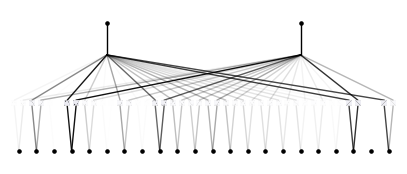

In [ ]:
best_model.plot()

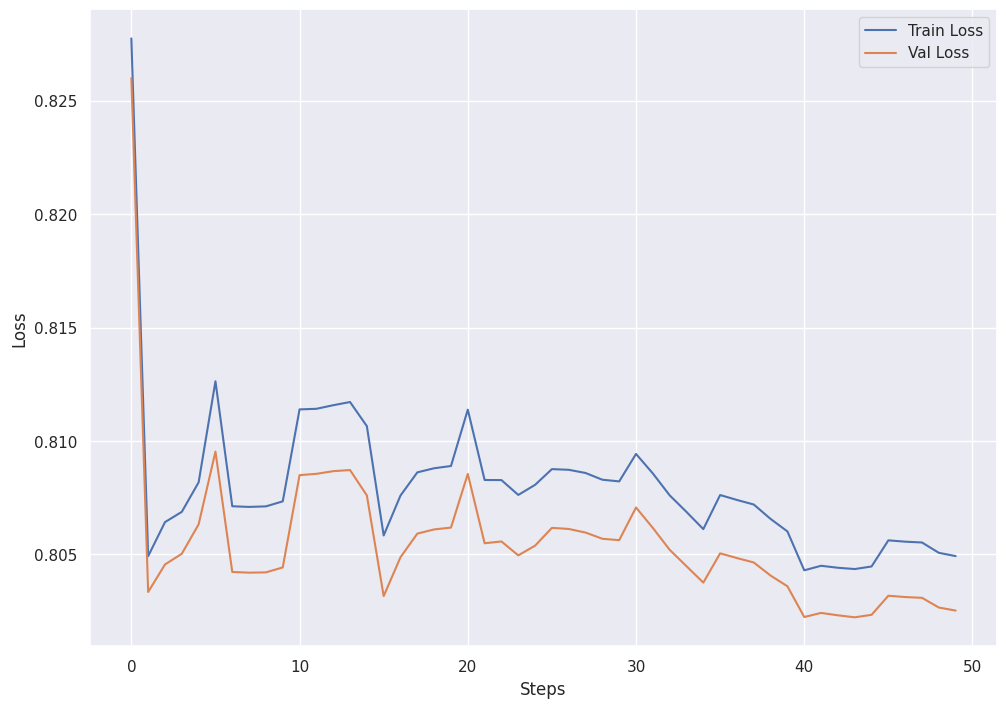

In [ ]:
# Plotar os resultados de losss (opcional)
plt.plot(best_result['train_loss'], label='Train Loss')
plt.plot(best_result['test_loss'], label='Val Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

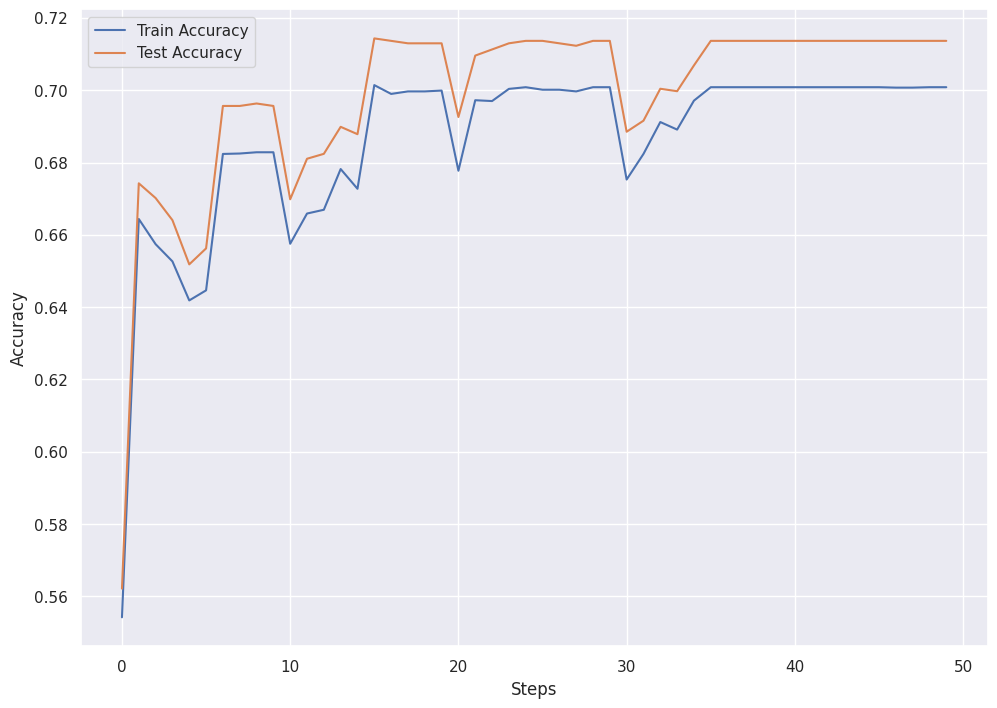

In [ ]:
# Plotar os resultados de acurácia (opcional)
plt.plot(best_result['train_acc'], label='Train Accuracy')
plt.plot(best_result['test_acc'], label='Test Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()